In [21]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from scipy.io.idl import readsav

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from specutils import Spectrum1D
import specutils.manipulation

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [16]:
path = '/media/david/5tb_storage1/muscles/kf_cos/'
savs= glob.glob('{}*sav'.format(path))
print(savs)

['/media/david/5tb_storage1/muscles/kf_cos/GJ674_COS130M_Mm1_NOSCL_03apr18.sav', '/media/david/5tb_storage1/muscles/kf_cos/GJ849_G130M_Mm1_NOSCL_10june19.sav', '/media/david/5tb_storage1/muscles/kf_cos/LP_756_18_COS160M_Mm1_NOSCL_10aug19.sav', '/media/david/5tb_storage1/muscles/kf_cos/GJ1132_COSallFUV_Mm1_NOSCL_22apr19.sav', '/media/david/5tb_storage1/muscles/kf_cos/GJ163_COS130M_Mm1_NOSCL_10july2019.sav', '/media/david/5tb_storage1/muscles/kf_cos/GJ163_COS160M_Mm1_NOSCL_09july2019.sav', '/media/david/5tb_storage1/muscles/kf_cos/GJ649_COS130M_NOSCL_Mm1_06mar18.sav', '/media/david/5tb_storage1/muscles/kf_cos/GJ676A_v2_G130M_Mm1_NOSCL_07apr19.sav', '/media/david/5tb_storage1/muscles/kf_cos/GJ699_G130M_NOSCL_Mm1_04mar19.sav', '/media/david/5tb_storage1/muscles/kf_cos/GJ849_G160M_Mm1_NOSCL_10june19.sav', '/media/david/5tb_storage1/muscles/kf_cos/LHS2686_COS130M_Mm1_NOSCL_01june2019.sav', '/media/david/5tb_storage1/muscles/kf_cos/LP_756_18_COS130M_Mm1_NOSCL_10aug19.sav', '/media/david/5tb_s

/media/david/5tb_storage1/muscles/kf_cos/TRAPPIST1_G130M_Mm1_NOSCL_10dec2018.sav


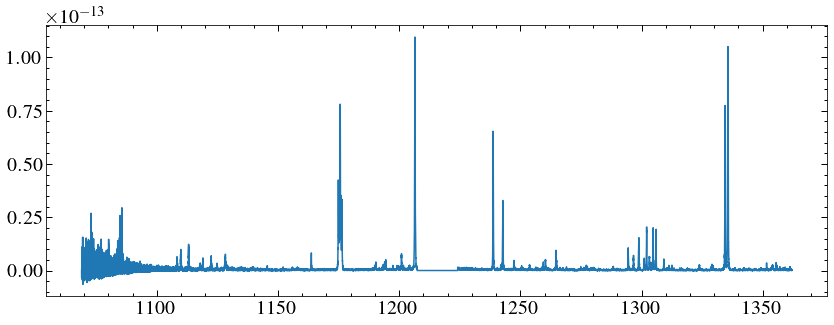

In [86]:
print(savs[-2])
data = readsav(savs[0])
w, f, e = data['wave'],data['flux'], data['err']
plt.plot(w, f)

(-1e-15, 1e-14)

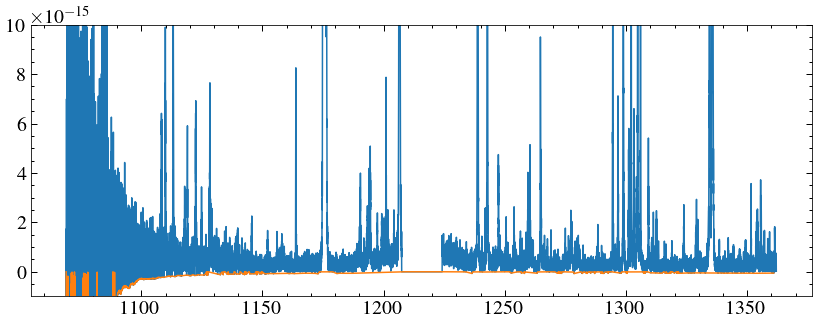

In [87]:
nmask = (f <= 0.0)
plt.plot(w,f)
plt.plot(w[nmask], f[nmask])
plt.ylim(-0.01e-13, 0.1e-13)

In [88]:
print(len(f), len(f[nmask]))

29389 3349


Specutils?

In [89]:
# spec = Spectrum1D(spectral_axis=w*u.AA, flux=f*u.erg/u.s/u.cm**2/u.s) 


3349


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.


132
1
0
29389 24639
4.9508603631360964e-14
4.951315220725706e-14
4.965956393711018e-13
4.963201612536662e-13


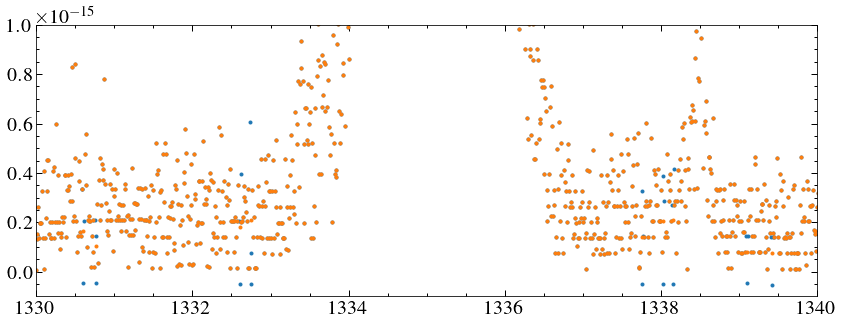

In [90]:
fo= f
wo= w

nz = len(fo[fo <=0.0])
# print(inds)
print(nz)
while nz > 0:
    
    fn = []
    wn = []
    inds = []
    for i in range(len(fo)):
        if fo[i] <= 0.0:
#             if i > 0 & i < len(fo):
    #         inds.append(i)
            inds.append(i-1)
            inds.append(i+1)
    #         print(f[i])
    #         print(f[i-1:i+2])
            fn.append(np.mean(fo[i-1:i+2]))
            wn.append(np.mean(wo[i-1:i+2]))
        else:
            wn.append(wo[i])
            fn.append(fo[i])
    inds = np.unique(inds)
    fn = np.delete(np.array(fn), inds)
    wn = np.delete(np.array(wn), inds)
    nz = len(fn[fn <=0.0])
    fo = fn
    wo = wn
    print(nz)
    
# print(inds)
# print(len(f[nmask]))
# print(len(np.array(fn)[np.array(fn)<=0.0]))
wn, fn = np.array(wn), np.array(fn)
# plt.step(w,f)
# plt.step(wn, fn)
plt.plot(w,f, '.')
plt.plot(wn,fn, '.')

print(len(w), len(wn))
plt.xlim(1330, 1340)
plt.ylim(-0.1e-15, 1e-15)
print(np.trapz(f[(w> 1330)  & (w < 1340)],w[(w> 1330)  & (w < 1340)]))
print(np.trapz(fn[(wn> 1330)  & (wn < 1340)],wn[(wn> 1330)  & (wn< 1340)]))

print(np.sum(f[(w> 1330)  & (w < 1340)])/10)
print(np.sum(fn[(wn> 1330)  & (wn < 1340)])/10)

ok...does it work on T-1?Yes?

Function it up:

In [125]:
def no_zero_errors(flux, error):
    """
    Corrects instances where negative flux measurements have very small errors
    """
    e_new = error
    for i in range(len(error)):
        if flux[i] < 0.0 and error[i] < 0.1*abs(flux[i]):
            e_new[i] = abs(flux[i])
    return e_new

def remove_negatives(w, f, e):
    print(len(f))
    wo, fo, eo = w, f, e
    nz = len(fo[fo <=0.0])
    print(nz)
    while nz > 0:
        fn = []
        wn = []
        en = []
        inds = []
        for i in range(len(fo))[1:-1]:
            if fo[i] <= 0.0:
                inds.append(i-1)
                inds.append(i+1)
                weights = 1 / (eo[i-1:i+2]**2)
                fn.append(np.average(fo[i-1:i+2],weights=weights))
                wn.append(np.mean(wo[i-1:i+2]))
                en.append((1 / np.sum(weights, axis=0))**0.5)
            else:
                wn.append(wo[i])
                fn.append(fo[i])
                en.append(eo[i])
        inds = np.unique(inds)
        wn, fn, en = np.array(wn), np.array(fn), np.array(en)
        print(len(fn))
        wn, fn, en  = np.delete(wn, inds), np.delete(fn, inds), np.delete(en, inds)
        print(len(fn))
        nz = len(fn[fn <=0.0])
        wo, fo, eo =wn, fn, en
        print(nz)
    return(wn, fn, en)


/media/david/5tb_storage1/muscles/kf_cos/GJ674_COS130M_Mm1_NOSCL_03apr18.sav
28386
2346


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


28384
24881
0
3.115006821619934e-13
3.689188924537684e-13


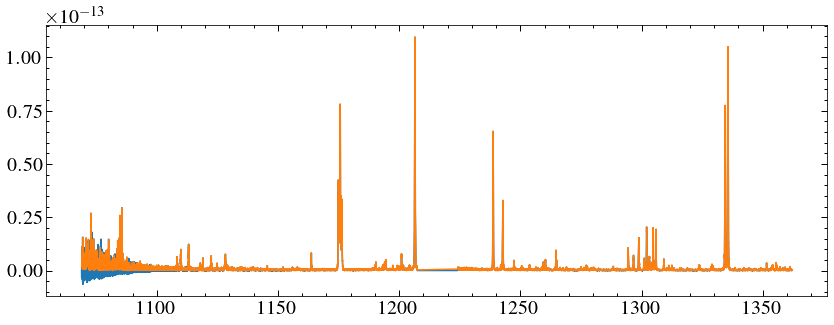

/media/david/5tb_storage1/muscles/kf_cos/GJ849_G130M_Mm1_NOSCL_10june19.sav
28787
11492


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


28785


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


11665
0
4.4308265961360835e-14
5.895646896264248e-14


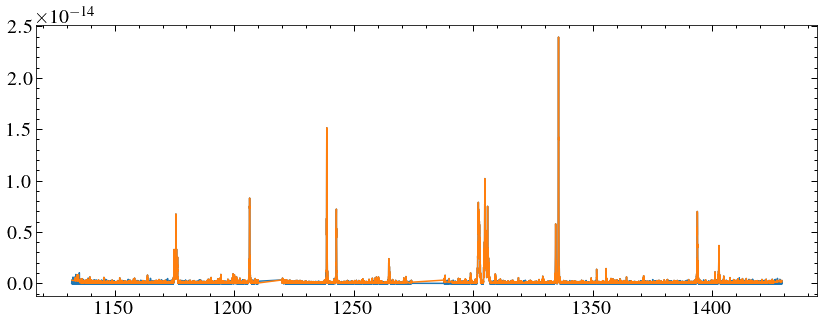

/media/david/5tb_storage1/muscles/kf_cos/LP_756_18_COS160M_Mm1_NOSCL_10aug19.sav
32191
24477


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


32189


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


1911
0
-9.349503136211452e-16
8.905223786014931e-14


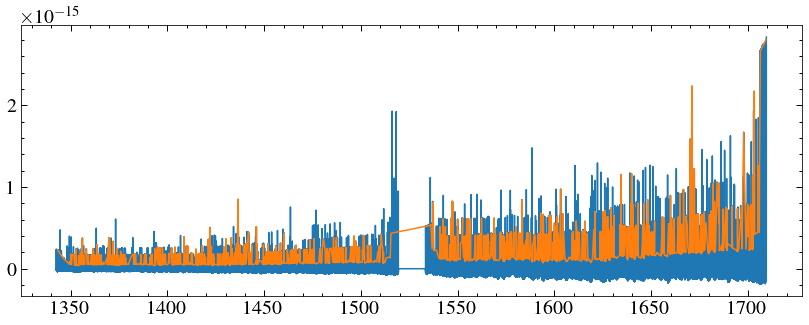

/media/david/5tb_storage1/muscles/kf_cos/GJ1132_COSallFUV_Mm1_NOSCL_22apr19.sav
58606
38731


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


58604


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


8282
0
9.8122632241816e-15
1.3895483260167185e-13


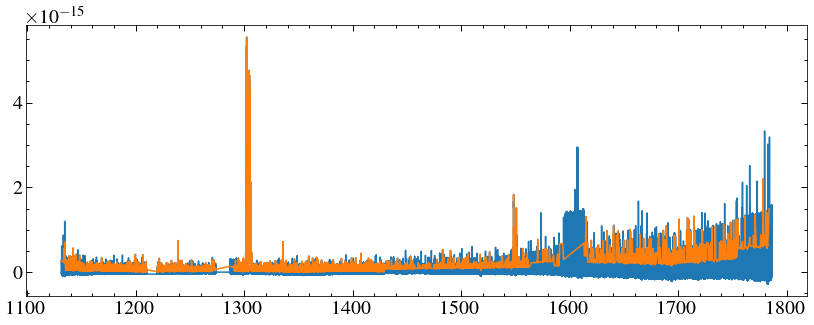

/media/david/5tb_storage1/muscles/kf_cos/GJ163_COS130M_Mm1_NOSCL_10july2019.sav
28787
15362


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


28785


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


6933
0
1.45618656180695e-14
3.1168169110648353e-14


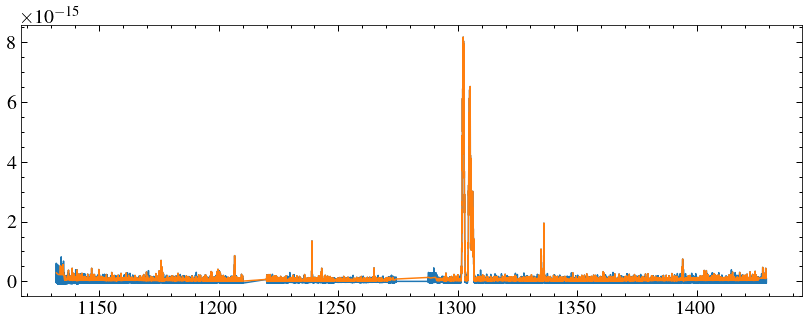

/media/david/5tb_storage1/muscles/kf_cos/GJ163_COS160M_Mm1_NOSCL_09july2019.sav
33366
23397


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


33364


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


3273
0
3.9919358554984456e-16
9.094085123042456e-14


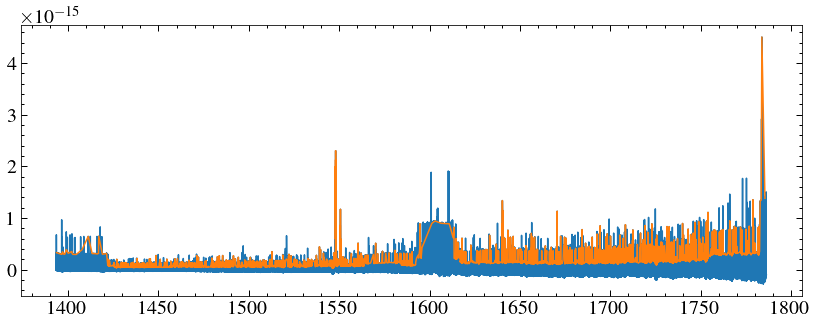

/media/david/5tb_storage1/muscles/kf_cos/GJ649_COS130M_NOSCL_Mm1_06mar18.sav
28687
10237


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


28685


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


12718
0
3.924137677016298e-14
1.3145643709259534e-13


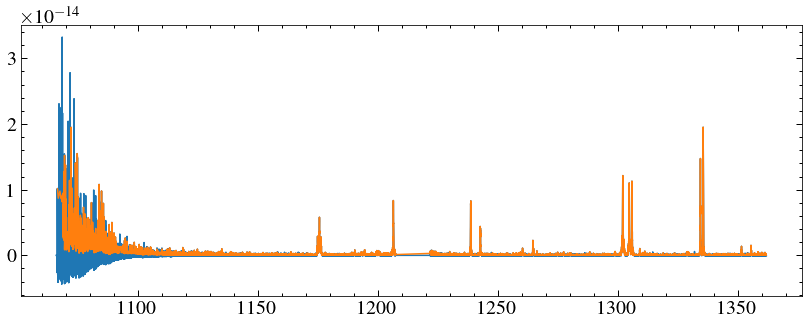

/media/david/5tb_storage1/muscles/kf_cos/GJ676A_v2_G130M_Mm1_NOSCL_07apr19.sav
28687
9520


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


28685


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


13812
0
5.322842529565564e-14
1.589138907264165e-13


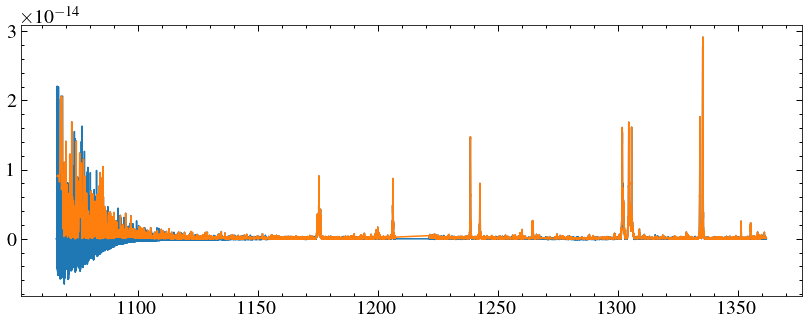

/media/david/5tb_storage1/muscles/kf_cos/GJ699_G130M_NOSCL_Mm1_04mar19.sav
28687
6628


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


28685
17876
0
6.075784021844936e-14
1.561108049313369e-13


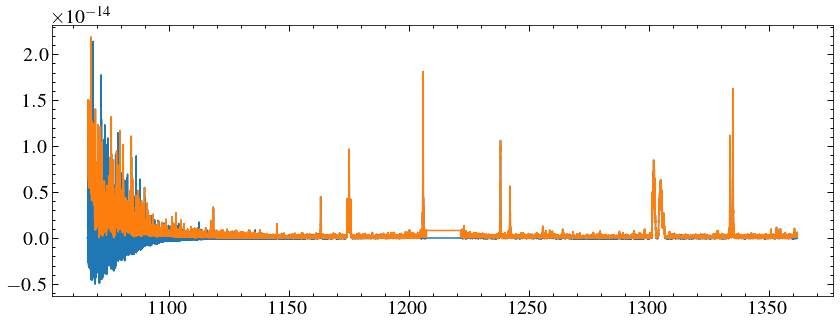

/media/david/5tb_storage1/muscles/kf_cos/GJ849_G160M_Mm1_NOSCL_10june19.sav
30172
20083


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


30170


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


4064
0
3.563974187269372e-14
1.3996927904033116e-13


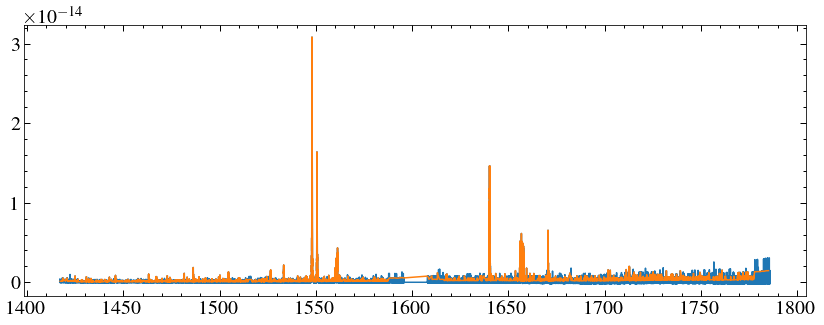

/media/david/5tb_storage1/muscles/kf_cos/LHS2686_COS130M_Mm1_NOSCL_01june2019.sav
29188
10472


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


29186


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


12892
0
3.869402189799116e-14
1.4877427552163472e-13


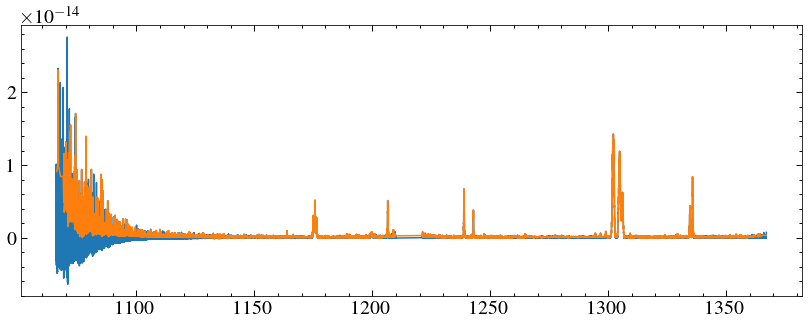

/media/david/5tb_storage1/muscles/kf_cos/LP_756_18_COS130M_Mm1_NOSCL_10aug19.sav
28887
17782


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


28885


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


4579
0
6.841531621723744e-17
2.1360841776530394e-14


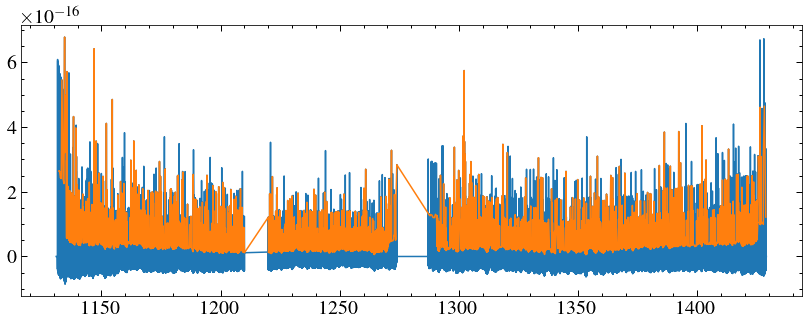

/media/david/5tb_storage1/muscles/kf_cos/L_980_5_G130M_Mm1_NOSCL_14mar19.sav
28787
16655


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


28785


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


5743
0
3.548053066807285e-15
2.169849661103731e-14


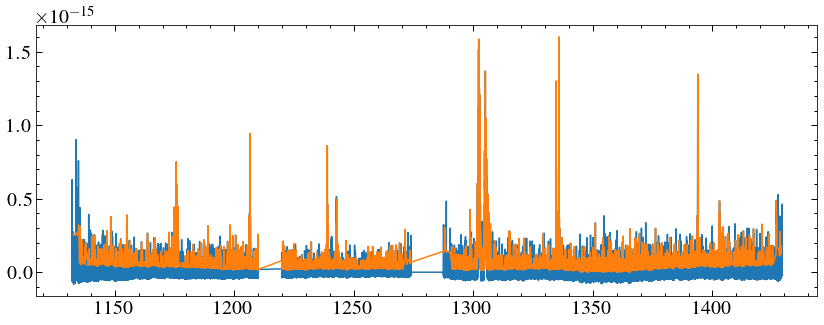

/media/david/5tb_storage1/muscles/kf_cos/L_980_5_G160M_Mm1_NOSCL_14mar19.sav
32488
20212


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


32486


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


5028
0
6.754453636187326e-16
5.870893706321032e-14


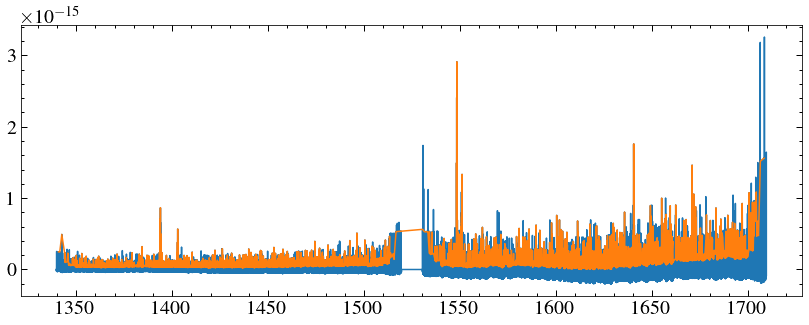

/media/david/5tb_storage1/muscles/kf_cos/TRAPPIST1_G130M_Mm1_NOSCL_10dec2018.sav
28787
15977


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


28785


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


6477
0
1.8484832727108597e-14
3.705511462451378e-14


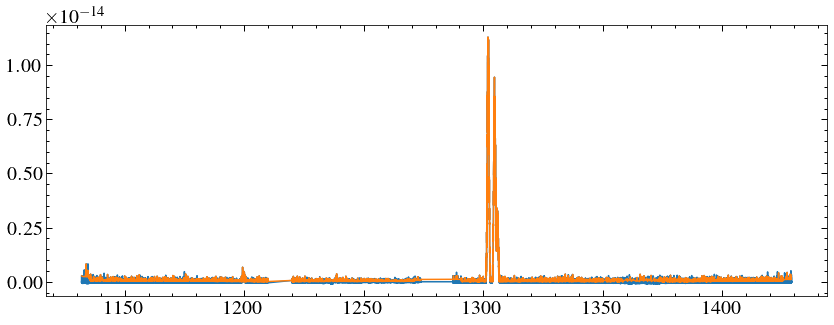

/media/david/5tb_storage1/muscles/kf_cos/TRAPPIST1_G160M_3orb_Mm1_NOSCL_09dec2018.sav
31808
24178


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


31806


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


2103
0
-5.482863277414538e-15
1.1852547760549338e-13


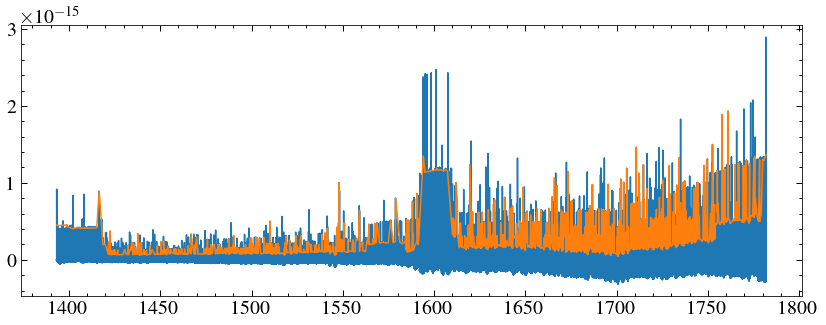

In [126]:
for sav in savs:
    print(sav)
    data = readsav(sav)
    w, f, e = np.array(data['wave']),np.array(data['flux']), np.array(data['err'])
    mask = (w < 1210) | (w > 1220)
    w, f, e = w[mask],f[mask],e[mask]
    e = no_zero_errors(f, e)
    wn, fn, en = remove_negatives(w, f, e)
    plt.plot(w, f)
    plt.plot(wn,fn)
    print(np.trapz(f, w))
    print(np.trapz(fn, wn))
    plt.show()

In [114]:
a = np.array([1,2, 3])
print(a.flags)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

